---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: true
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

### Word Cloud
- for each driver
- top 10 most frequent words in their respective news articles

In [2]:
# import required libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
import seaborn as sns

In [3]:
# Function to generate a word cloud for a single JSON file
def generate_wordcloud_top_n(file_path, output_folder, top_n=10):
    def plot_cloud(wordcloud, output_file):
        plt.figure(figsize=(10, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(output_file) 

        plt.close()

    # Read the text from the JSON file
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Concatenate all text content if it's a JSON dictionary
    if isinstance(data, dict):
        my_text = ' '.join(data.values())

    # Generate word cloud to extract word frequencies
    wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",  
        colormap="Blues",  
        collocations=False,
        stopwords=STOPWORDS
    ).generate(my_text)

    # Extract word frequencies and get the top N words
    word_frequencies = wordcloud.words_
    top_words = dict(list(word_frequencies.items())[:top_n])

    # Generate a new word cloud with only the top N words
    top_wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",  
        colormap="Blues",
        collocations=False,
        stopwords=STOPWORDS
    ).generate_from_frequencies(top_words)

    # Save and display the word cloud
    file_name = os.path.basename(file_path).replace('.json', '_wordcloud.png')
    output_file = os.path.join(output_folder, file_name)
    plot_cloud(top_wordcloud, output_file)


# Function to process all JSON files in a folder
def generate_wordclouds_for_folder(input_folder, output_folder, top_n=10):
    os.makedirs(output_folder, exist_ok=True)  

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.json'):  # Process only JSON files
            file_path = os.path.join(input_folder, file_name)
            try:
                generate_wordcloud_top_n(file_path, output_folder, top_n)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")


In [4]:
input_folder = "../../data/processed-data/News_Drivers/" 
output_folder = "../../data/eda/WordClouds/"  
generate_wordclouds_for_folder(input_folder, output_folder, top_n=20)

In [5]:
# add each word cloud and interpretation 
# change the theme

# word clouds
![Alonso](../../data/eda/WordClouds/Alonso_clean_news_wordcloud.png)

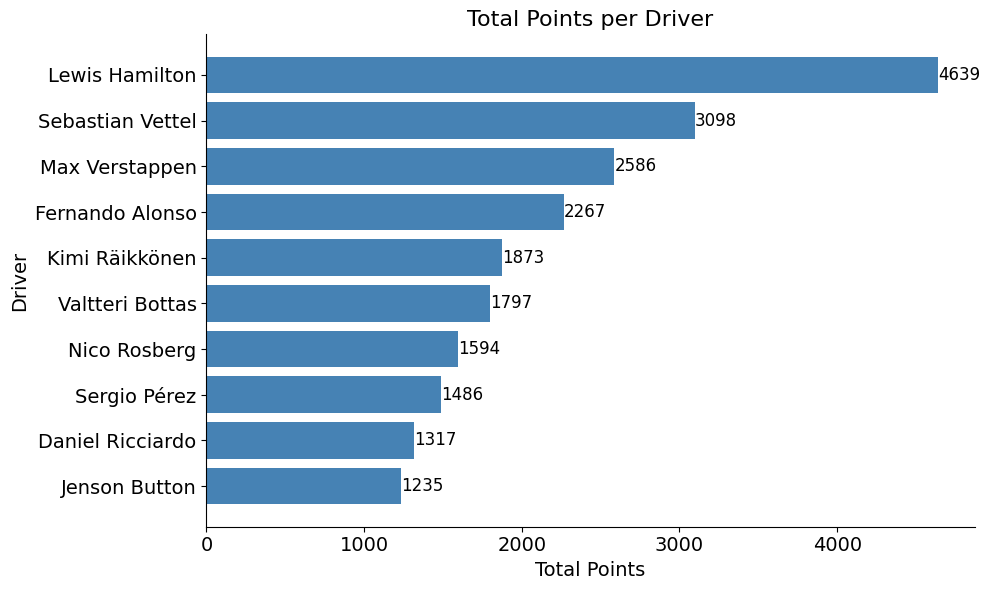

In [14]:
# number of points by driver
data = pd.read_csv("../../data/processed-data/driver_standings_2000_2023.csv")
# Calculate total points for each driver
total_points = data.groupby("driverName")["Points"].sum().reset_index()


top_10_drivers = total_points.sort_values(by="Points", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_drivers["driverName"], top_10_drivers["Points"], color="steelblue")

for bar in bars:
    plt.text(
        bar.get_width() + 1, 
        bar.get_y() + bar.get_height() / 2,  
        f'{int(bar.get_width())}',  
        va='center', fontsize=12, color='black'
    )
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Total Points", fontsize=14)
plt.ylabel("Driver", fontsize=14)
plt.title("Total Points per Driver", fontsize=16)
plt.gca().invert_yaxis()  
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


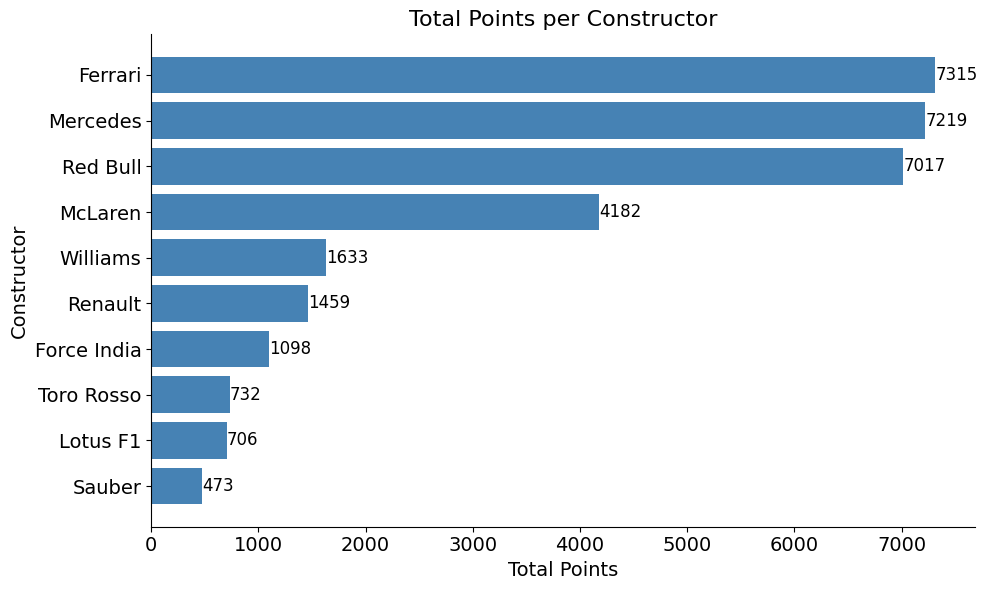

In [15]:
total_points = data.groupby("Constructor_Name")["Points"].sum().reset_index()


constructors = total_points.sort_values(by="Points", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(constructors["Constructor_Name"], constructors["Points"], color="steelblue")

for bar in bars:
    plt.text(
        bar.get_width() + 1, 
        bar.get_y() + bar.get_height() / 2,  
        f'{int(bar.get_width())}',  
        va='center', fontsize=12, color='black'
    )
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Total Points", fontsize=14)
plt.ylabel("Constructor", fontsize=14)
plt.title("Total Points per Constructor", fontsize=16)
plt.gca().invert_yaxis()  
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


In [28]:
# points scored by driver over time with different teams
def plot_driver_points(data, driver_name, color_list=None):

    driver_data = data[data['driverName'] == driver_name].sort_values(by='Season')
    

    unique_constructors = driver_data["Constructor_Name"].unique()
    if color_list:

        constructor_colors = {
            constructor: color_list[i % len(color_list)]
            for i, constructor in enumerate(unique_constructors)
        }
    else:
        constructor_colors = {
            constructor: plt.cm.tab10(i / len(unique_constructors))
            for i, constructor in enumerate(unique_constructors)
        }
    plt.figure(figsize=(10, 6))
    

    for i in range(len(driver_data) - 1):
        season_start = driver_data.iloc[i]['Season']
        season_end = driver_data.iloc[i + 1]['Season']
        points_start = driver_data.iloc[i]['Points']
        points_end = driver_data.iloc[i + 1]['Points']
        constructor = driver_data.iloc[i]['Constructor_Name']
        

        plt.plot(
            [season_start, season_end],
            [points_start, points_end],
            color=constructor_colors[constructor],
            linewidth=4
        )
    

    for _, row in driver_data.iterrows():
        plt.text(row['Season'], row['Points'], str(row['Points']), fontsize=12, ha='center')
    

    plt.title(f"Points Over Seasons for {driver_name}", fontsize=16)
    plt.xticks(fontsize = 14, rotation = 90)
    plt.yticks(fontsize = 14)
    plt.xlabel("Season", fontsize=14)
    plt.ylabel("Points", fontsize=14)
    plt.tight_layout()
    plt.xticks(range(int(driver_data["Season"].min()), int(driver_data["Season"].max()) + 1))


    legend_elements = [
        mlines.Line2D([], [], color=constructor_colors[constructor], label=constructor, linewidth=3)
        for constructor in unique_constructors
    ]
    plt.legend(handles=legend_elements, loc="upper left", fontsize=14)
    

    plt.show()

color_list = ["lightskyblue", "cornflowerblue", "deepskyblue", "powderblue", "steelblue", "lightblue"]


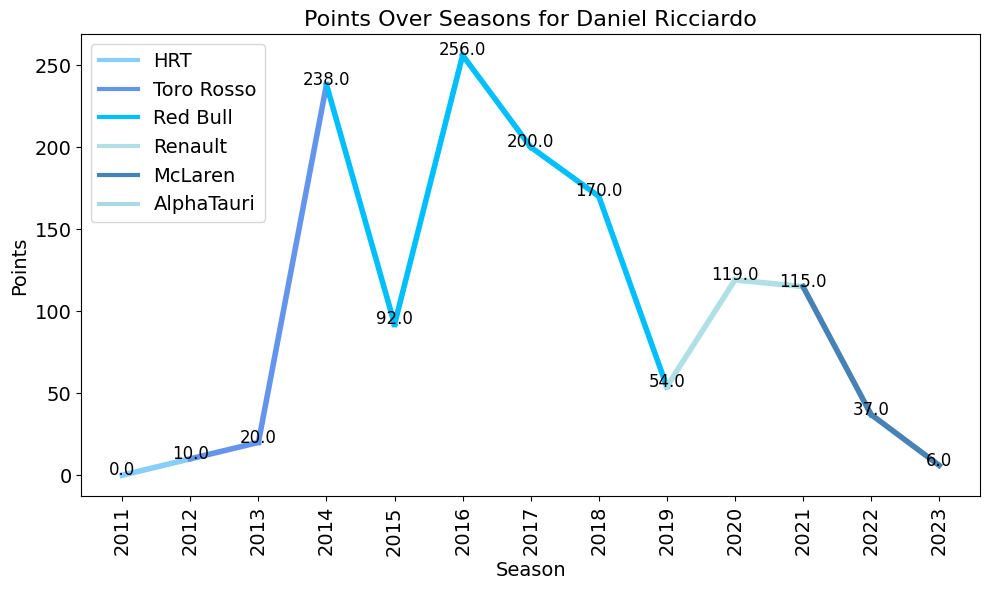

In [32]:
plot_driver_points(data, "Daniel Ricciardo", color_list)

In [3]:
# distribution of "Lapped", "Mechanical", "Accident" across Constructors
data = pd.read_csv("../../data/processed-data/race_info.csv")


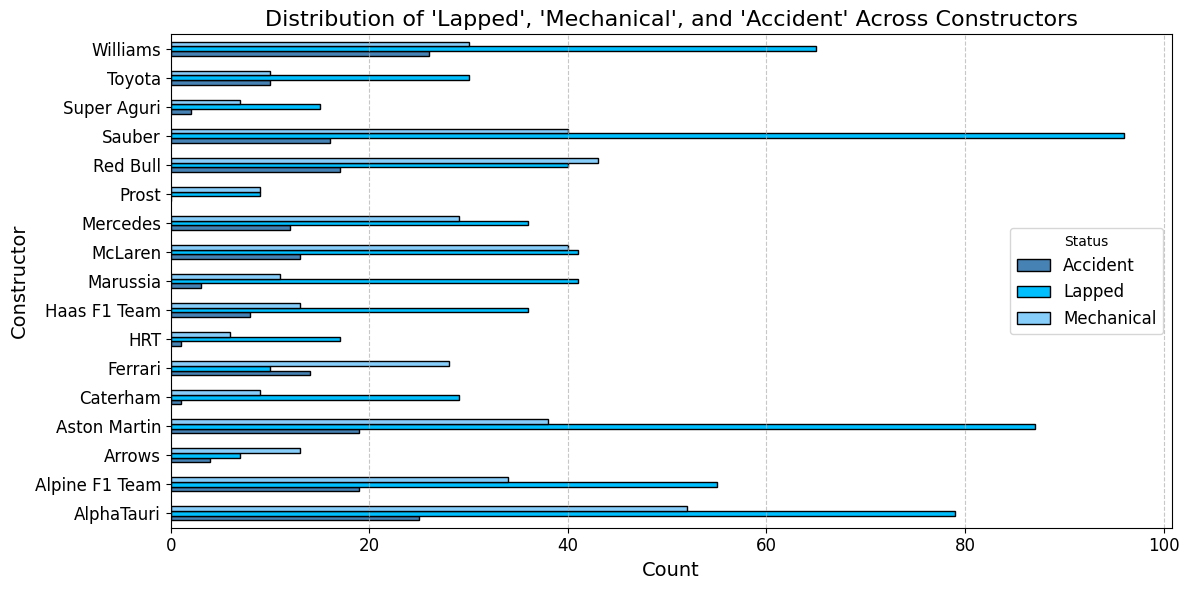

In [78]:
# Filter the data for specific statuses
filtered_data = data[data["status"].isin(["Lapped", "Mechanical", "Accident"])]

# Group by constructor and status to get counts
status_distribution = filtered_data.groupby(["constructorName", "status"]).size().unstack(fill_value=0)

# Plot the distribution with horizontal bars
status_distribution.plot(
    kind="barh",
    figsize=(12, 6),
    color=['steelblue', 'deepskyblue', 'lightskyblue'],  
    edgecolor="black"
)

# Customize the plot
plt.title("Distribution of 'Lapped', 'Mechanical', and 'Accident' Across Constructors", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Constructor", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Status", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


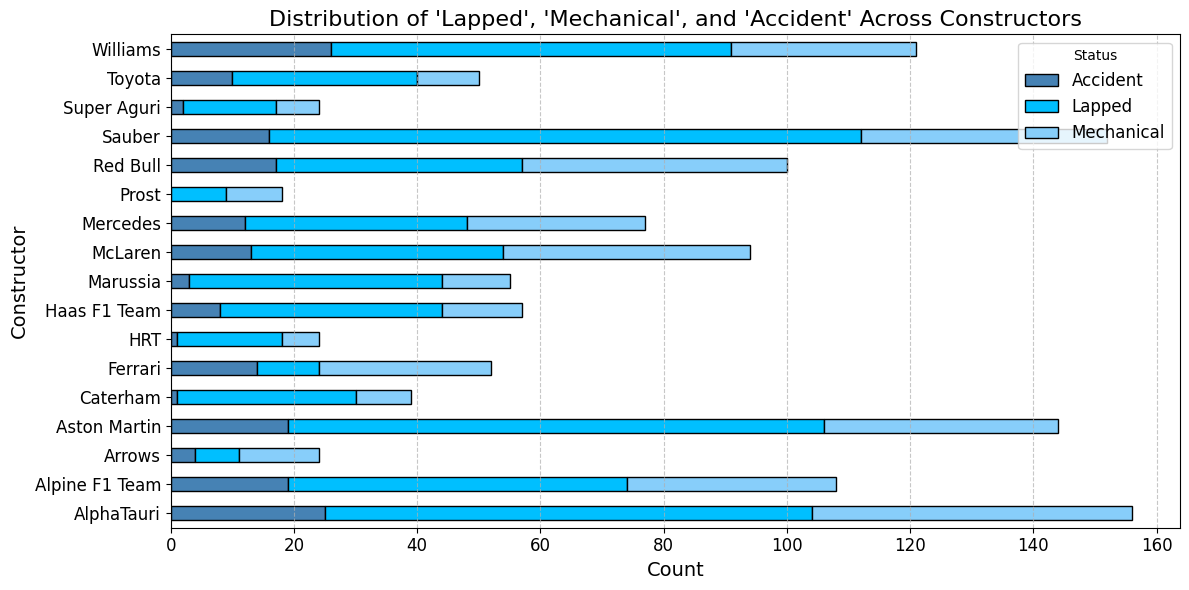

In [79]:
# Filter the data for specific statuses
filtered_data = data[data["status"].isin(["Lapped", "Mechanical", "Accident"])]

# Group by constructor and status to get counts
status_distribution = filtered_data.groupby(["constructorName", "status"]).size().unstack(fill_value=0)

# Plot the distribution as a stacked horizontal bar chart
status_distribution.plot(
    kind="barh",
    figsize=(12, 6),
    color=['steelblue', 'deepskyblue', 'lightskyblue'],  
    edgecolor="black",
    stacked=True  # Make the bars stacked
)

# Customize the plot
plt.title("Distribution of 'Lapped', 'Mechanical', and 'Accident' Across Constructors", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Constructor", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Status", fontsize=12, loc="upper right")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


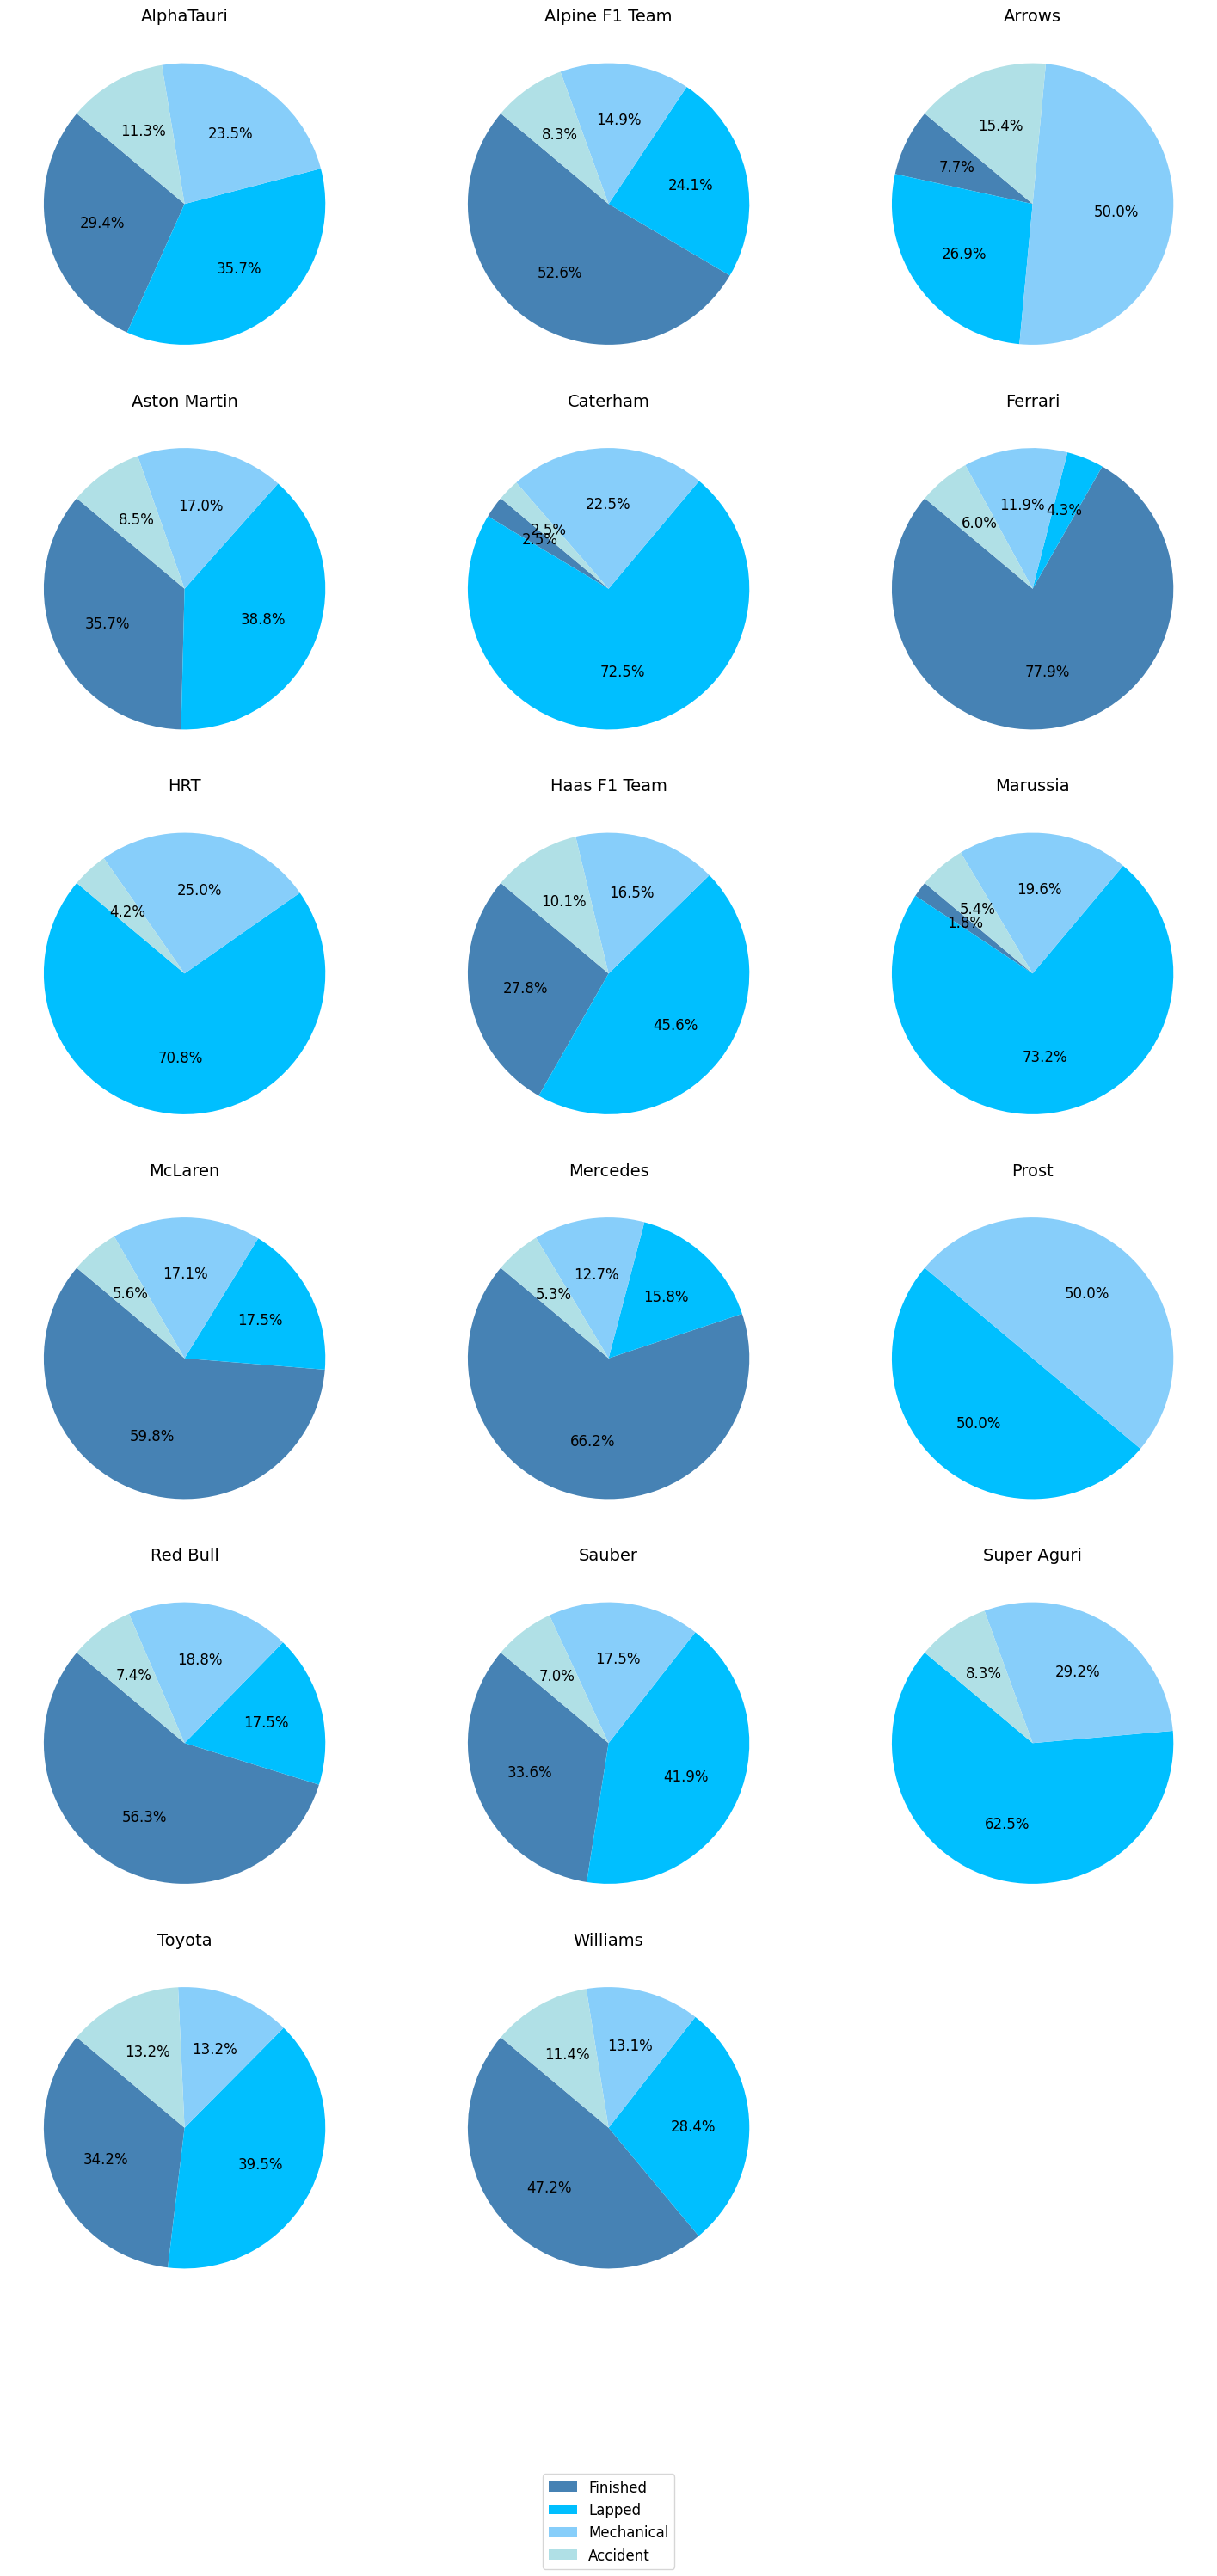

In [80]:
# distrbution of status for each constructor 
def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 0 else ''


filtered_data = data[data["status"].isin(["Finished", "Lapped", "Mechanical", "Accident"])]


status_distribution = filtered_data.groupby(["constructorName", "status"]).size().unstack(fill_value=0)


status_distribution["Total"] = data.groupby("constructorName").size()


num_constructors = len(status_distribution)
num_cols = 3
num_rows = (num_constructors + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))


axes = axes.flatten()

colors = ['steelblue', 'deepskyblue', 'lightskyblue', 'powderblue']


for idx, constructor in enumerate(status_distribution.index):
    status_counts = status_distribution.loc[constructor, ["Finished", "Lapped", "Mechanical", "Accident"]]
    total_count = status_distribution.loc[constructor, "Total"]
    

    percentages = (status_counts / total_count) * 100


    wedges, texts, autotexts = axes[idx].pie(
        percentages,
        labels=None,  
        autopct=autopct_format,
        colors=colors,
        startangle=140,
        textprops={'fontsize': 10} 
    )
    axes[idx].set_title(f"{constructor}", fontsize=14)

    for autotext in autotexts:
        autotext.set_fontsize(12)  


for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Add a shared legend
fig.legend(
    labels=["Finished", "Lapped", "Mechanical", "Accident"],
    loc="lower center",
    ncol=1,
    fontsize=12
)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 1])  
plt.show()


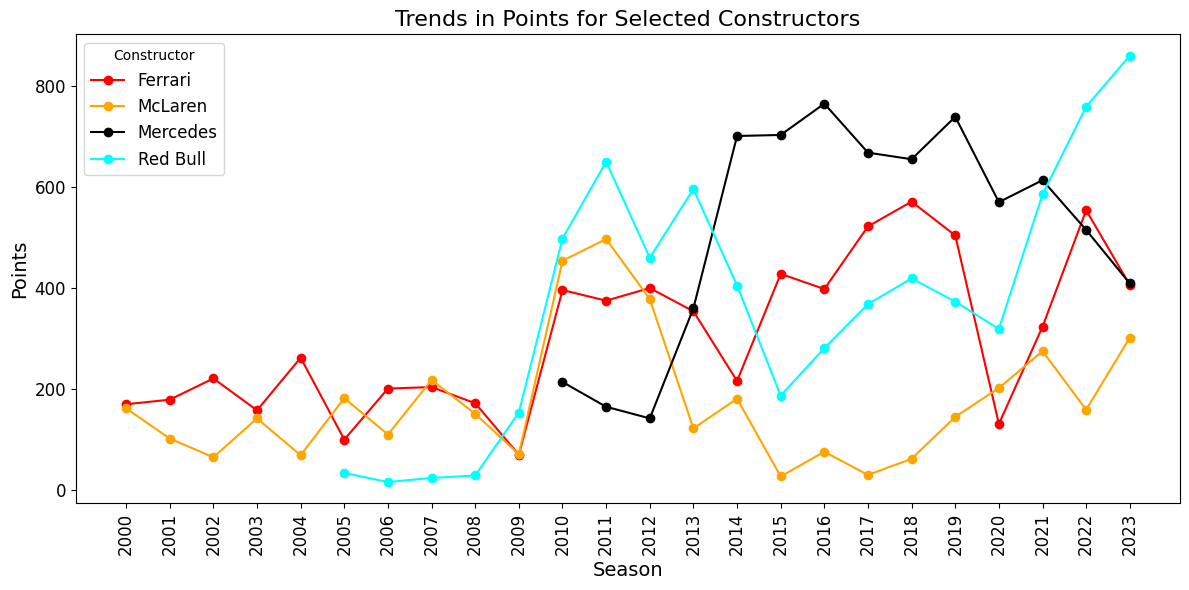

In [95]:
# trends in teams scoring points across seasons - for "Red Bull", "Ferrari", "McLaren", "Mercedes"
data = pd.read_csv("../../data/processed-data/driver_standings_2000_2023.csv")


filtered_data = data[data["Constructor_Name"].isin(["Red Bull", "Ferrari", "McLaren", "Mercedes"])]


grouped_data = filtered_data.groupby(["Season", "Constructor_Name"])["Points"].sum().unstack()


color_list = ["red", "orange", "black", "aqua"]


unique_constructors = grouped_data.columns
constructor_colors = {constructor: color_list[i % len(color_list)] for i, constructor in enumerate(unique_constructors)}


plt.figure(figsize=(12, 6))
for constructor in grouped_data.columns:
    plt.plot(
        grouped_data.index, 
        grouped_data[constructor], 
        marker='o', 
        label=constructor, 
        color=constructor_colors[constructor]
    )


plt.title("Trends in Points for Selected Constructors", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Points", fontsize=14)
plt.xticks(grouped_data.index, rotation=90, fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(title="Constructor", fontsize=12)
plt.tight_layout()


plt.show()

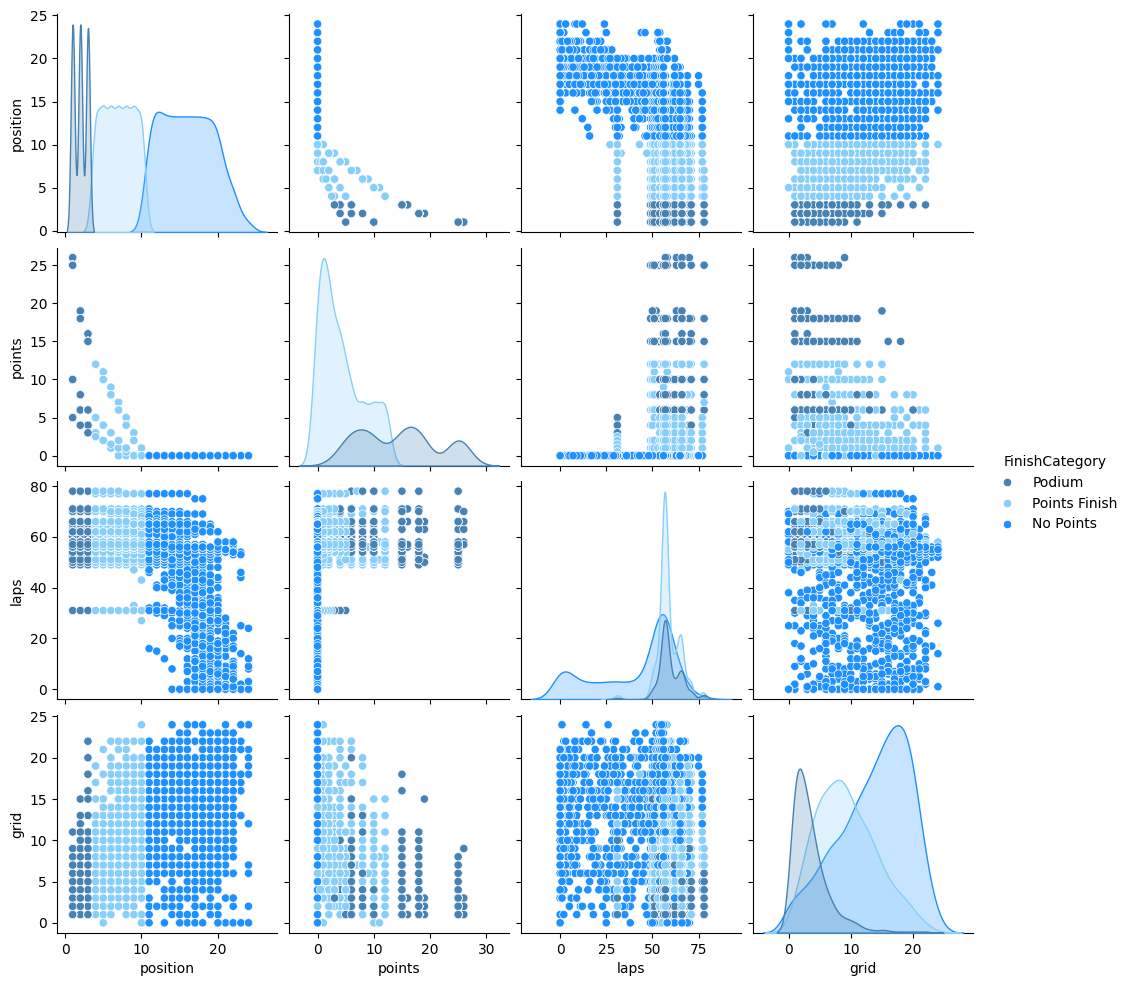

In [11]:
sns.pairplot(data[['position', 'points', 'laps', 'grid', 'FinishCategory']], hue='FinishCategory', palette={'Podium':'steelblue', 'Points Finish':'lightskyblue', 'No Points': 'dodgerblue'})